In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,BatchNormalization, Activation,  GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import MobileNetV2
from keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import HTML

2023-12-22 07:57:56.263296: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 07:57:56.265646: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 07:57:56.321014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 07:57:56.321064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 07:57:56.322200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Kuliah/Pengolahan Citra Digital/Capstone Project - Stress Emotion

In [2]:
train_dir = "Dataset/train/" #passing the path with training images
test_dir = "Dataset/test/"   #passing the path with testing images

In [3]:
def jumlah(path, set_):
    dict_ = {}
    for tingkatan in os.listdir(path):
        dir_ = path + tingkatan
        dict_[tingkatan] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

print(jumlah(train_dir, 'train'))
print(jumlah(test_dir, 'test'))

       fear  angry  disgust  happy  neutral  sad
train   500    500      500    510      500  500
      fear  angry  disgust  happy  neutral  sad
test   150    150      111    160      150  160


In [4]:
img_size = 48 #original size of the image

"""
Augmentasi Data
--------------------------
rotasi_range = memutar gambar dengan besaran derajat yang kita sediakan
width_shift_range = menggeser gambar secara acak ke kanan atau ke kiri sepanjang lebar gambar
height_shift range = menggeser gambar secara acak ke atas atau ke bawah sepanjang tinggi gambar
horizontal_flip = membalik gambar secara horizontal
rescale = untuk memperkecil nilai pizel pada gambar kita antara 0 dan 1
zoom_range = menerapkan zoom acak pada objek kita
validation_split = mencadangkan beberapa gambar untuk digunakan untuk tujuan validasi
"""

In [5]:
#train_datagen/validation_datagen = variable
#ImageDataGenerator = fungsi

train_datagen = ImageDataGenerator(     width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         zoom_range = 0.2,
                                         featurewise_center = False,
                                         rotation_range = 10
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,)

In [6]:
"""
Applying data augmentation to the images as we read
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    class_mode = "categorical",
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              shuffle = True,
                                                              class_mode = "categorical",

                                                             )

Found 3010 images belonging to 6 classes.
Found 881 images belonging to 6 classes.


In [7]:
class_labels = validation_generator.class_indices
class_labels

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

In [8]:
#Melihat shape
train_sample = next(train_generator)
print(train_sample[0].shape)

(64, 48, 48, 3)


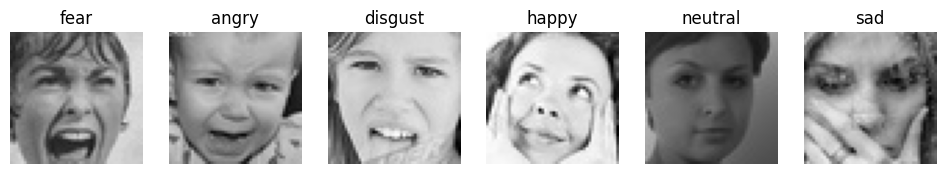

In [10]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = image.load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [11]:
# Resnet50

base_model = tf.keras.applications.MobileNetV2(input_shape= (48,48,3),include_top=False,weights="imagenet")
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 24, 24, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 24, 24, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 24, 24, 32)           0         ['bn_Conv1[

In [12]:
for layer in base_model.layers:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Activation('relu'))
model.add(Dense(6, activation='softmax'))


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2

In [14]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [15]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

In [16]:
history = model.fit(train_generator,validation_data = validation_generator, epochs=60, verbose=1, callbacks=[lrd,mcp,es])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 2.6340 - accuracy: 0.7844 - precision: 0.1910 - recall: 0.0907 - auc: 0.5141 - f1_score: 0.1338

/home/mangg/Downloads/Capstone Project - Stress Emotion-20231221T133651Z-001/Capstone Project - Stress Emotion/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 37s 473ms/step - loss: 2.6340 - accuracy: 0.7844 - precision: 0.1910 - recall: 0.0907 - auc: 0.5141 - f1_score: 0.1338 - val_loss: 1.8703 - val_accuracy: 0.8318 - val_precision: 0.1000 - val_recall: 0.0011 - val_auc: 0.5007 - val_f1_score: 0.0022 - lr: 1.0000e-04
Epoch 2/60
48/48 [==============================] - 24s 495ms/step - loss: 2.5914 - accuracy: 0.7833 - precision: 0.1748 - recall: 0.0807 - auc: 0.5074 - f1_score: 0.1217 - val_loss: 1.8588 - val_accuracy: 0.8328 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4928 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/60
48/48 [==============================] - 24s 487ms/step - loss: 2.6034 - accuracy: 0.7823 - precision: 0.1566 - recall: 0.0698 - auc: 0.5014 - f1_score: 0.0940 - val_loss: 1.8312 - val_accuracy: 0.8330 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5030 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/60
48/48 [=====================

In [17]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_generator)
test_evaluation = model.evaluate(validation_generator)

14/14 [==============================] - 1s 74ms/step - loss: 1.7701 - accuracy: 0.8337 - precision: 0.5833 - recall: 0.0079 - auc: 0.5824 - f1_score: 0.0158


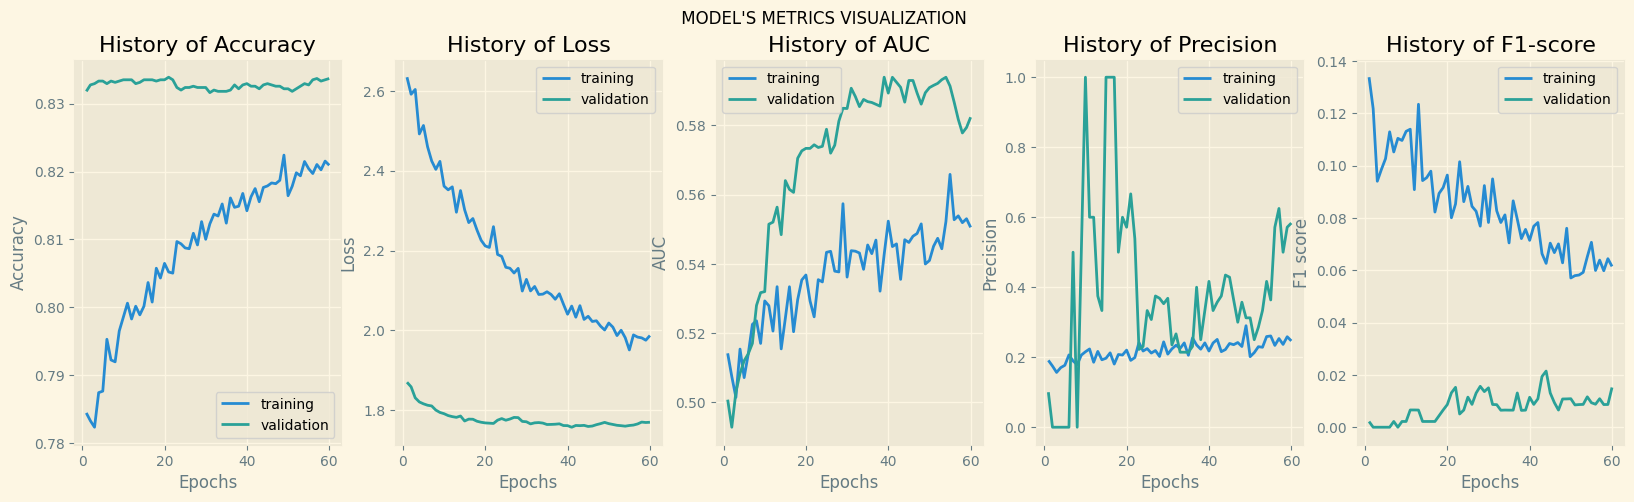

In [18]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weight.h5")
print("Saved model to disk")

In [ ]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='Dataset/test/sad/PrivateTest_1495838.jpg'
test_image=image.load_img(img_path,target_size= (48,48,3),color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [ ]:
img=image.load_img('sad.jpg',target_size=(48,48,3))
img = np.expand_dims(img, axis=0)
print(img.shape)

In [ ]:
classes=['fear', 'angry', 'disgust', 'happy', 'neutral', 'sad']

result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])